# Sparkify - Data Sciene Capstone

## Project

Sparkify is a music streaming service similar to Google Music or Amazon Music. The data provided is an activity log of a subset of users. The activity log includes information such as the page visited, actions take, type of browser used, first name, last name and other variables. The scope of this project is to create a machine learning model that can predict users who churn (users who opt out of the service). This is important for a business which relies on customer subscriptions to generate revenue and maintain a presence in the market.
<br>

The steps followed in this notebook are:
#### Initial setup
- Importing Libraries

#### ETL
- Loading the Data From AWS S3
- Glance at Data
- Looking for Missing Values
- Feature Extraction

#### EDA
- Feature Correlations
- Data Balance (looking for under-represented data)
- Differences Amongst Users

#### Machine Learning Pipeline
- Pipeline & Metrics
- Models
- Fitting
- Predicting
- Results & Performance

#### Discussion
- What do the results mean?
- What can we learn from the models?

#### Other Notes
How I set up the problem to save as much money as I could.
- installed spark on my local Linux machine
- installed aws service on my machine
- downloaded the small snippet of data on my local linux machine to later run on the large dataset

## Importing Libraries

The main library I will be using is pyspark with the intention of running it on an AWS EMR cluster, as the data is roughly 16GB and cannot be loaded on the memory of most computers all at once (there are steps to load data in chunks, but that is beyond the scope of this project). I will be using PySpark for loading the data, cleaning, feature extraction as well as the machine learning. <br>
For some of the EDA I will be using Pandas, Numpy, Matplotlib and Seaborn; after feature extraction I expect the data size to be reduced significantly such that it can be loaded in the memory. Once the data becomes easier to read on memory it will be easier to use pandas and the other graphic libraries to display the results.

In [1]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import MinMaxScaler
from pyspark.sql import types as T
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import *
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

# Read in full sparkify dataset


## Import Data

I originally imported the small dataset named <code><b>mini_sparkify_event_data.json</b></code>, I used the smaller dataset in order to develop my initial workflow on my local computer. When I was close to finishing my project I used the full dataset on the AWS EMR cluster. <br>

In [2]:
event_data = "/home/juggernaut/Documents/mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.createOrReplaceTempView("data")
print('shape of data is {}, {}'.format(df.count(),len(df.columns)))

shape of data is 286500, 18


What does the data look like? Looking at the schema will be useful to understand the columns.

In [3]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



What does one entry look like?

In [4]:
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

We can see that each row contains information that can be very useful, such as level, page and some that we do not know how useful it would be such as gender, ts and itemInSession. There are also columns that I will not use such as firstName, lastName, location, method, registration, status, userAgent. <br>
<b>userId</b> will be the key used to pull features for each user.

### Missing Values

In [5]:
predrop=df.count()
df.dropna()
postdrop = df.count()
print('{} rows were dropped, NaNs account for {} % of the data'\
      .format(predrop-postdrop,100*(predrop-postdrop)/predrop))
# there are no NaNs

0 rows were dropped, NaNs account for 0.0 % of the data


### Drop Columns

I do not intend to use all the columns in this data, some of it will not help to derive statistical differences between groups, and will only add unnecessary information to the data.

In [6]:
drop_columns =['artist', 'firstName','lastName','song', 'useAgent','location','method',\
               'registration']
for col in drop_columns:
    df.drop(col)

### Feature Engineering
In this dataset, a users actions are portrayed in the <code>page</code> column. Below are all possible values of the page column:

In [7]:
pages=[x.page for x in spark.sql('''SELECT DISTINCT(page) FROM data''').collect()]
print(pages)

['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Submit Registration', 'Settings', 'Login', 'Register', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


The "churn" indicator is when a user goes to the "Submit Downgrade" page, effectively dropping the level of their account from "paid" to "free". In this data we are only interested in users who using the "paid" level of the service. <br>
<br>
Seeing that user actions will make up the features in this dataset, I create the feature dataframe by counting how many times a user has gone through each action, and also how much time they have spent using the app overall.

In [107]:
labeler = lambda x: 1 if x>0 else 0 # a small function o generate labels
                                    #if a user goes through the submit downgrade page
labelfunc = F.udf(labeler,IntegerType())
convert_to_int=F.udf(int,IntegerType())
# this SQL Query will take care of the feature exctraction from the data
features=spark.sql('''
SELECT userId,
gender,
COUNT(page) AS n_pages,
COUNT(IF(page='Cancel',1,NULL)) AS n_cancel,
COUNT(IF(page='Submit Downgrade',1,NULL)) AS n_sub_downgrade,
COUNT(IF(page='Thumbs Down',1,NULL)) AS n_thumb_down,
COUNT(IF(page='Home',1,NULL)) AS n_home,
COUNT(IF(page='Downgrade',1,NULL)) AS n_downgrade,
COUNT(IF(page='Roll Advert',1,NULL)) AS n_roll_advert,
COUNT(IF(page='Cancellation Confirmation',1,NULL)) AS n_cancellation,
COUNT(IF(page='About',1,NULL)) AS n_about,
COUNT(IF(page='Submit Registration',1,NULL)) AS n_submit_registration,
COUNT(IF(page='Cancel',1,NULL)) AS n_cancel,
COUNT(IF(page='Login',1,NULL)) AS n_login,
COUNT(IF(page='Register',1,NULL)) AS n_register,
COUNT(IF(page='Add to Playlist',1,NULL)) AS n_add_playlist,
COUNT(IF(page='NextSong',1,NULL)) AS n_nextsong,
COUNT(IF(page='Thumbs Up',1,NULL)) AS n_thumb_up,
COUNT(IF(page='Error',1,NULL)) AS n_error,
COUNT(IF(page='Submit Upgrade',1,NULL)) AS n_submit_upgrade,
SUM(length) AS total_length
FROM data 
GROUP BY userId,gender
''')

features.createOrReplaceTempView("features")

features = features.withColumn("label",labelfunc("n_sub_downgrade"))
features = features.withColumn("gender", F.when(F.col("gender")=="M", 0).otherwise(1))
features = features.withColumn("total_length",F.col("total_length").cast(FloatType()))

## EDA

Now that the features matrix is computed, it is easy to import this smaller dataset into pandas, and leverage pandas dataframe functions.

In [108]:
featuredf = features.toPandas()

### Feature Correlations & Differences

It is worth exploring whether there are certain correlations between our features, and whether these correlations are significant when it comes to whether a user churned.
<br>

I chose to use Kendall's Tau Correlation as I am more interested in whether things tend to be moving in the same direction rather than in the same amount.

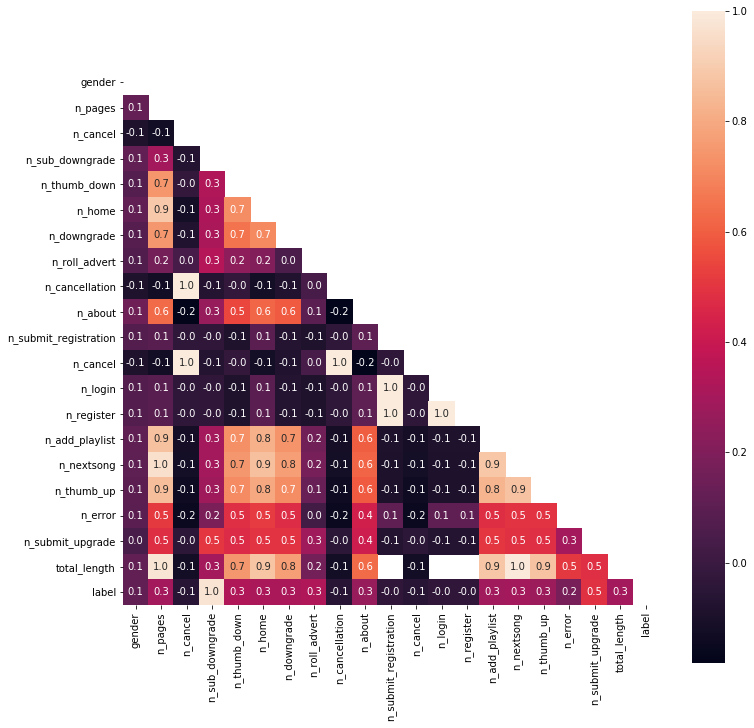

In [109]:
plt.figure(figsize=(12,12),facecolor='white')
corr = featuredf.corr(method='kendall')
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True, fmt='.1f', square=True, mask = mask)

We can see clear correlations between features such as n_add_playlist, and n_nextsong,n_thump_up and n_length. This correlation makes sense as they represent the time that a user has interacted with the service; thus the more a user interacts with the service the more actions they will have, which is also represented by a high correlation of n_length and n_pages. <br>
I am mainly interested in the correlations of <code>label</code> as that is what I will attempt to predict. I will not be looking into n_sub_downgrade(as <code>label</code> was derived using the information from that column). 

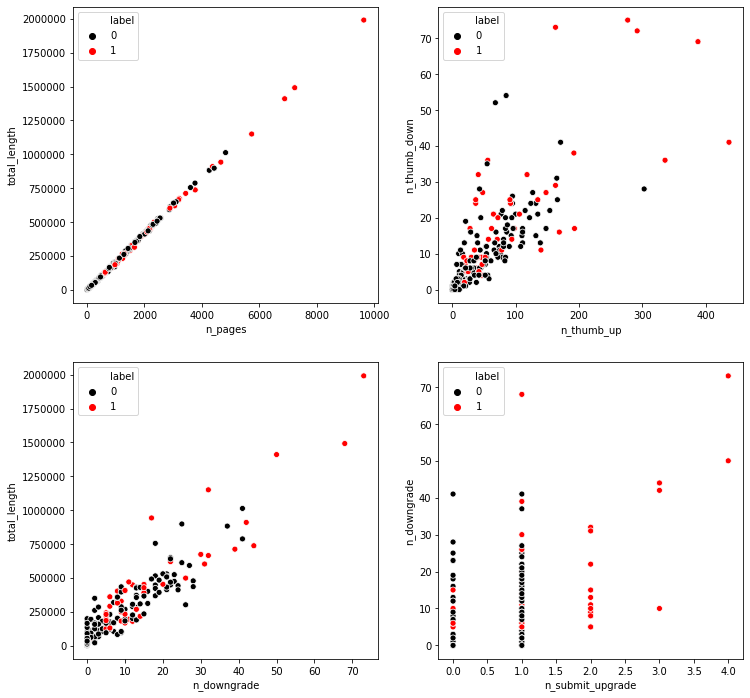

In [110]:
plt.figure(figsize=(12,12),facecolor='white')
plt.subplot(2,2,1)
sns.scatterplot(x='n_pages',y='total_length',hue='label',data=featuredf,
               palette = ['#000000', '#FF0000'])
plt.subplot(2,2,2)
sns.scatterplot(x='n_thumb_up',y='n_thumb_down',hue='label',data=featuredf,
               palette = ['#000000', '#FF0000'])
plt.subplot(2,2,3)
sns.scatterplot(x='n_downgrade',y='total_length',hue='label',data=featuredf,
               palette = ['#000000', '#FF0000'])
plt.subplot(2,2,4)
sns.scatterplot(x='n_submit_upgrade',y='n_downgrade',hue='label',data=featuredf,
               palette = ['#000000', '#FF0000'])


It is hard to indentify whether there is a direct correlation plot that clearly sepperates users who churned and who did not. But from the 4th plot, it is clear that users who went to the submit upgrade page more than once have a tendency to churn later. These are probably users who are debate whether to upgrade into the platform or not. 

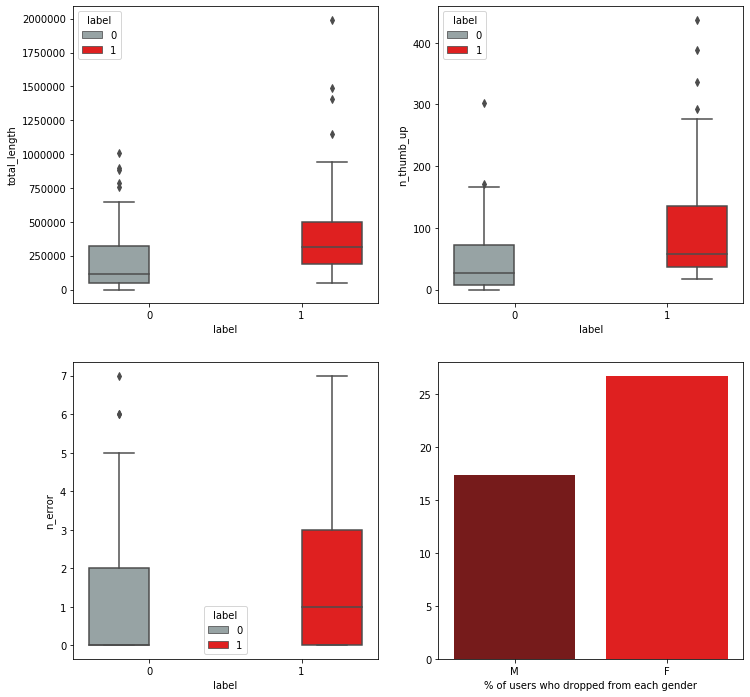

In [111]:
plt.figure(figsize=(12,12),facecolor='white')
plt.subplot(2,2,1)
sns.boxplot(x='label',y='total_length',hue='label',data=featuredf,
               palette = ['#95a5a6', '#FF0000'])
plt.subplot(2,2,2)
sns.boxplot(x='label',y='n_thumb_up',hue='label',data=featuredf,
               palette = ['#95a5a6', '#FF0000'])
plt.subplot(2,2,3)
sns.boxplot(x='label',y='n_error',hue='label',data=featuredf,
               palette = ['#95a5a6', '#FF0000'])
plt.subplot(2,2,4)
gendersums=featuredf.groupby('gender').sum()
gendercount=featuredf.groupby('gender').count()
vals=100*gendersums['label']/gendercount['userId']
sns.barplot(x=['M' , 'F'],y=vals,
               palette = ['#850c0c', '#FF0000'])
plt.xlabel('% of users who dropped from each gender');

We can observe some differences in these plots.Users who churn have a tendency to have used the service for longer. The service is struggling with keeping its users. <br>
Users who churned also tend to observe more errors in the service. <br>
There also seems to be a tendency for female users to churn more often, maybe the content/interface is not as appealing to them? (answering this question is beyond the scope of this project)

## Machine Learning Pipeline
### Pipeline & Metrics

For this project I will use more than one learning model, and compare how they perform compared to each other. <br>

In [112]:
print("{} % of the users churned".format\
      (np.round(100*featuredf['label'].sum()/featuredf.shape[0],2)))

21.68 % of the users churned


Seeing that only ~22% of the users churned, it would be unwise to use Accuracy as a metric for prediction performance. <br>

I chose to use the area under the ROC Curve to rank performance of each of learner. The Area under the ROC Curve is a plot using True Positive Rate and False Positive Rate. The area is at its highest when the True Postive Rate is at its highest, and False Postive Rate is at its lowest. <br>
A classifier that does a good job at sepperating classes, will have score closer to 1.0 . If I classifier has a score close to 0.5, it is doing a poor job at sepperating classes.

### Models

I will use 4 models to fit and classify.
- Logistic Regression
- Gradient Boosted Tree Classifier
- Random Forest Classifier
- Linear Support Vector Machine 

I chose these algorithms because they are already present in the spark framework, and they have different approaches to classification.<br>

Logistic Regression is based on the ability to combine features into a regression model, then applying a logistic function in the end to classify the outcome of the regression model. <br>
Gradient Boosted Tree Classifier is a boosting algorithm, which adjusts the its sepperation features by lowering the error rate at each repetition. <br>
Random Forest Classifier is a bagging algorithm. It is composed of multiple weak learners, who in the end vote on the possible outcome of a sample. Having multiple weak learners ususally prevents overfitting, while providing a powerful learner. <br>
Support Vector Machines try to sepperate classes by using all the feature dimensions available to them. The resulting SVM attempts to draw the "line" where it is maximally distant from both classes.

In [113]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, LogisticRegression, LinearSVC, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler,MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve,auc

evaluator = BinaryClassificationEvaluator()

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10, seed = 20)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10, seed = 20)
lsvc = LinearSVC(maxIter=10, regParam=0.1)
model_list = [lr,rf,gbt,lsvc]

In [114]:
features.select('gender').take(4)

[Row(gender=1), Row(gender=1), Row(gender=1), Row(gender=1)]

### Pipeline

The pipeline consists of scaling the features using <code> MinMaxScaler</code> and then using the <code> VectorAssembler</code> to collect the features. Data will then be fitteed by the learning model, the model will be tuned using cross validation, and the best model will be used for further evaluation.

In [121]:
columns = ['n_thumb_down','n_home','n_roll_advert','n_about',\
'n_submit_registration','n_login','n_add_playlist','n_nextsong',\
'n_thumb_up','n_error','n_submit_upgrade','gender']
assembler = VectorAssembler(inputCols= columns,outputCol='features_stage1')
scaler = MinMaxScaler(inputCol="features_stage1", outputCol="features")

### Fitting Tuning

Using <code>ParamGrid</code> I will tune the models chosen for evaulation.

In [123]:
lrgrid=ParamGridBuilder()\
.addGrid(lr.maxIter,[5,10,15,20])\
.addGrid(lr.regParam,[0.1,0.3,0.5])\
.addGrid(lr.elasticNetParam,[0.3,0.5,0.8])\
.build()


rfgrid=ParamGridBuilder()\
.addGrid(rf.numTrees,[10,20,30,40,50])\
.addGrid(rf.maxDepth,[2,3,5])\
.build()

gbtgrid=ParamGridBuilder()\
.addGrid(gbt.maxIter,[5,10,15,20])\
.build()

lsvcgrid=ParamGridBuilder()\
.addGrid(lsvc.maxIter,[5,10,15,20])\
.addGrid(lsvc.regParam, [0.01,0.1,0.5])\
.build()

grids= [lrgrid, rfgrid, gbtgrid, lsvcgrid]

Splitting the data into 80% training and 20% test.

In [124]:
train = features.sampleBy("label",fractions={0:0.8,1:0.8},seed=1)
test = features.subtract(train)

In [125]:
def spark_col_to_list(obj, column): # a helper function to get data into lists for sklearn
    outlist=obj.select(column).collect()
    try:
        outlist = [x[column].values for x in outlist]
    except:
        outlist = [x[column] for x in outlist]
    return outlist

0 Logistic Regression
Logistic Regression: 0.875
1 Random Forrest
Random Forrest: 0.8541666666666666
2 G.B Trees
G.B Trees: 0.7546296296296295
3 Linear SVC
Linear SVC: 0.8703703703703703


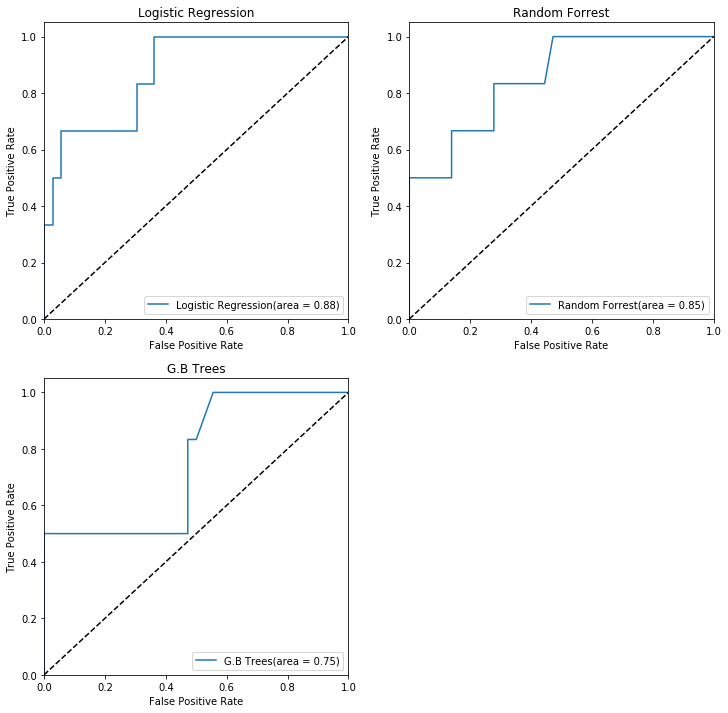

In [126]:
best_models = {}
model_names= ['Logistic Regression','Random Forrest', 'G.B Trees', 'Linear SVC']
plt.figure(figsize=(12,12))
#run through each model and perform tuning, then we perform AUC ROC Scoring and plotting
for n, model_name in enumerate(model_names):
    print(n,model_name)
    pipe=Pipeline(stages=[assembler,scaler, model_list[n]])
    crossval = CrossValidator(estimator=pipe,
                              estimatorParamMaps=grids[n],
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=5)
    cvModel=crossval.fit(train)
    bestmodel=cvModel.bestModel
    predictions=bestmodel.transform(test)
    score = evaluator.evaluate(predictions,{evaluator.metricName: "areaUnderROC"})
    print(""+model_name+": " + str(score))
    
    # there are variables needed to get the AUC ROC curves for the model
    # unfortunately this will not work for the Linear SVC as it does not 
    # output the probability column in each prediction
    try:
        prob=spark_col_to_list(predictions,'probability')
        pred=spark_col_to_list(predictions, 'prediction')
        labels= spark_col_to_list(predictions, 'label')

        prob1 = [x[1] for x in prob]
        fpr, tpr, thresholds = roc_curve(labels, prob1, pos_label=1);
        roc_auc = auc(fpr, tpr)

        #plot the AUC ROC curves
        plt.subplot(2,2,n+1)
        plt.plot(fpr, tpr, label=model_name+'(area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(model_name)
        plt.legend(loc="lower right")
    except: 
        pass
    #get all the variables in a dictionary to use later
    best_models[model_name]=bestmodel
    best_models[model_name+'_score']=score
    best_models[model_name+'_predictions_variables']=[prob,pred,labels]

## Discussion
Observing the scores of each model after tuning, 3 of the models performed fairly similiar, with only one model lagging behind in performance. <br>

An important question is, what can we learn from the models, is there a feature more important than the others?

Looking at the Random Forest model, feature importances are a part of the model.

In [139]:
lrmodel=best_models['Random Forrest'].stages[-1]

In [140]:
lrmodel.featureImportances

SparseVector(12, {0: 0.1515, 1: 0.1284, 2: 0.1872, 3: 0.0118, 6: 0.0889, 7: 0.1423, 8: 0.0361, 10: 0.2504, 11: 0.0034})

From feature importances it is observable that feature 4,5 and 9 do not have a value, thus they did not help in the modelling and predicting process and should not be considered important.

In [165]:
xticks=columns
for col in [xticks[4],xticks[5],xticks[9]]:
    xticks.remove(col)

Text(0.5, 1.0, 'Feature Importances')

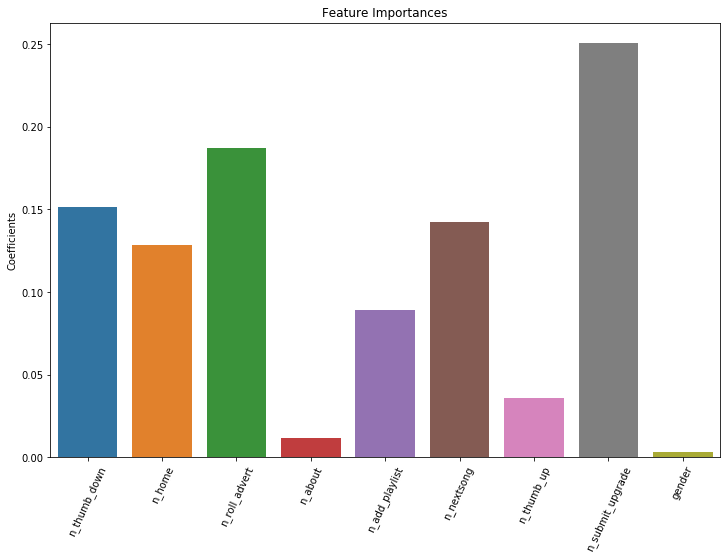

In [169]:
plt.figure(figsize=(12,8))
sns.barplot(x=np.linspace(1,len(xticks),len(xticks)),y=lrmodel.featureImportances.values)
plt.xticks(ticks=np.linspace(0,len(xticks)-1,len(xticks)),labels=xticks, rotation=65)
plt.ylabel('Coefficients')
plt.title('Feature Importances')

What is interesting about the graph above, is that one of the most useful features was the number of times a user did not like a song. Unfortunately, the advertisements and number of times they submitted to upgrade simply shows that a user opted to upgrade their account at some point (thus becoming a paid user). Although it was observed that female users had a slightly higher chance to opt out of the paid feature, it was barely significant in the decision making of the model.

## Improvement Considerations
The features can be further improved with some more domain knowledge. The currently available during development was 120MB, and 16GB on the AWS, developing on the AWS can be expensive, but performing EDA, and feature exploration on the AWS with the full data could lead to a more in depth exploration. 

## Other Notes
I initially ran the pipeline on the 120MB dataset, and this allowed me to quickly develop the data. <br>

I set up Spark 2.4.5 on my local linux machine so I could explore without the rush of getting charged for every hour. This took some time, but eventually I was satisfied with the ability to explore at my leisure without having to feel rushed. <br>
I had to also install aws service using pip, which allowed me to get the 120MB dataset from AWS S3 bucket of the Data Science NanoDegree program. <br>
